In [1]:
import numpy as np
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# data loading

In [3]:
patient_SnvIndel = pd.read_csv(
    "../combined.103patients.SNV_INDEL.maf", sep="\t", header=None)

patient_SnvIndel.columns = ["gene_name", "patient", "chrom", "start", "end", "cDNA", "AA_change", "type", "type1", "ref", "allele_wild", "allele_mutant", "dbSNP", "A_num", "C_num",
                            "G_num", "T_num", "vafs", "tree_pos", "percent"]

C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_14376\3812180891.py:1: DtypeWarning: Columns (13,14,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  patient_SnvIndel = pd.read_csv(


In [4]:
ci_improved = pd.read_csv("IM_data/ci_plus_geneticInfo_3th_improved1124.txt",sep="\t",encoding = "ISO-8859-1")

In [5]:
ci_sn = pd.read_csv("../ci_sn_20211210.txt",sep="\t")

In [6]:
filterd_samples = pd.read_csv("IM_data/ESCC_sequencza_jia.txt", sep="\t")
filterd_samples.index = filterd_samples["sample"]

In [7]:
ci_sn.index = filterd_samples.index.tolist()

In [8]:
# mark nonsynonymous-variants
nonsy_mu = ["De_novo_Start_InFrame", "De_novo_Start_OutOfFrame", "Frame_Shift_Del", "Frame_Shift_Ins",
            "In_Frame_Del", "In_Frame_Ins", "Missense_Mutation", "Nonsense_Mutation", "Nonstop_Mutation",
            "Splice_Site", "Start_Codon_Del", "Start_Codon_Ins", "Start_Codon_SNP", "Stop_Codon_Del", "Stop_Codon_Ins"]

# Immunoediting score

- Compute number immunogenic mutation per coding mutation

In [8]:
B_hat = np.sum(ci_sn["Immunogenic_mutations"])/np.sum((ci_sn["Nonsilent_clonal"]+ci_sn["Nonsilent_subclonal"] + ci_sn["Silent_subclonal"] + ci_sn["Silent_clonal"] ))

- predict the probability of bening nonsynonymous mutations per coding mutations based on context

In [15]:
def predicted_nonsy_mutations(patient_mutations):
    SNV_contet = pd.read_csv("IM_data/escc.mut.context.txt",sep="\t",header=None,index_col=0)[1].to_dict()
    silent_context_count = {}
    nonsy_context_count = {}

    for i,line in patient_mutations.iterrows():
        context = line["chrom"].replace("chr","") + ":" + np.str(line.start) + "_" + line.ref + "/" + line.allele_mutant

    #    if line["patient"] in ["ESCC012","ESCC049","ESCC061"]: ## remove hyper-methylation samples
    #        continue
        if context not in SNV_contet:
            continue
        info = SNV_contet[context] + "_" + line.ref + "/" + line.allele_mutant

        if line["type"] == "Silent":
            if info not in silent_context_count:
                silent_context_count[info] = 0
            silent_context_count[info] += 1
        if line["type"] in nonsy_mu:
            if info not in nonsy_context_count:
                nonsy_context_count[info] = 0
            nonsy_context_count[info] += 1
    
    for context in pd.read_csv("IM_data/total.NS_mutation_rate.txt",sep="\t",header=None)[0].tolist():
        if context not in silent_context_count:
            silent_context_count[context] = 1
        if context not in nonsy_context_count:
            nonsy_context_count[context] = 1    
    return silent_context_count,nonsy_context_count

In [19]:
silent_context_count,nonsy_context_count = predicted_nonsy_mutations(patient_SnvIndel)

C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\691069088.py:7: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  context = line["chrom"].replace("chr","") + ":" + np.str(line.start) + "_" + line.ref + "/" + line.allele_mutant


In [20]:
probability_of_nonsy = {}
for context in silent_context_count:
    #print(context,silent_context_count[context],nonsy_context_count[context],sep="\t")
    probability_of_nonsy[context] = nonsy_context_count[context]/(silent_context_count[context] + nonsy_context_count[context])

In [21]:
probability_of_nonsy

{'GGA_G/A': 0.6984536082474226,
 'TGA_G/A': 0.6021395822720326,
 'TCA_C/G': 0.769090909090909,
 'CCG_C/T': 0.6408746846089151,
 'GAC_A/T': 0.9090909090909091,
 'CGC_G/A': 0.6849557522123894,
 'CGT_G/A': 0.62426614481409,
 'AGA_G/A': 0.5560040363269425,
 'ACG_C/T': 0.6333021515434986,
 'AAG_A/G': 0.5882352941176471,
 'ACG_C/A': 0.8095238095238095,
 'TCA_C/T': 0.5890710382513661,
 'CCC_C/A': 0.7732558139534884,
 'TAG_A/G': 0.6896551724137931,
 'CGG_G/A': 0.6407528641571195,
 'TCT_C/T': 0.5496417604912999,
 'TCG_C/T': 0.6955602536997886,
 'TGG_G/A': 0.5723905723905723,
 'CAC_A/G': 0.7068965517241379,
 'GCG_C/T': 0.6893028846153846,
 'CGA_G/A': 0.7072192513368984,
 'GCA_C/T': 0.6688963210702341,
 'TGA_G/C': 0.7687116564417178,
 'GCT_C/T': 0.5391849529780565,
 'CCT_C/T': 0.4507042253521127,
 'TCG_C/G': 0.8170103092783505,
 'TAT_A/G': 0.7983870967741935,
 'AAA_A/G': 0.7307692307692307,
 'AAG_A/C': 0.8177570093457944,
 'CCC_C/G': 0.6436781609195402,
 'TCT_C/G': 0.9181818181818182,
 'TCC_C/G':

- Predict the number of nonsynomous mutations & immunogenetic mutations based on total number of coding mutations

In [22]:
def predicted_nonsy_count(mutation_cohort,silent_context_count,nonsy_context_count,B_hat,probability_of_nonsy):
    SNV_contet = pd.read_csv("IM_data/escc.mut.context.txt",sep="\t",header=None,index_col=0)[1].to_dict()
    
    filtered_contexts = []
    for con in silent_context_count:
        if silent_context_count[con] >= 10:
            filtered_contexts.append(con)
            
    predicted_nonsy = 0
    coding_mutations = 0
    for i,line in mutation_cohort.iterrows():
        context = line["chrom"].replace("chr","") + ":" + np.str(line.start) + "_" + line.ref + "/" + line.allele_mutant
        
        if context not in SNV_contet:
            continue
            
        if line["type"] == "Silent" or line["type"] in nonsy_mu:      
            info = SNV_contet[context] + "_" + line.ref + "/" + line.allele_mutant        
            predicted_nonsy += probability_of_nonsy[info]
            coding_mutations += 1
            
    return np.round(predicted_nonsy,1),np.round(coding_mutations*B_hat,1)

In [48]:
def compute_expected_samplelevel(mutations, patient, probability_of_nonsy, ci_sn):
    pat_mu = mutations[mutations["patient"] == patient]
    silent_context_count = {}
    nonsy_context_count = {}

    SNV_contet = pd.read_csv("IM_data/escc.mut.context.txt",
                             sep="\t", header=None, index_col=0)[1].to_dict()
    
    sn_to_IM = {}
    
    for i, line in pat_mu.iterrows():
        context = line["chrom"].replace(
            "chr", "") + ":" + np.str(line.start) + "_" + line.ref + "/" + line.allele_mutant
        if context not in SNV_contet:
            continue
        info = SNV_contet[context] + "_" + line.ref + "/" + line.allele_mutant

        if line["type"] == "Silent":
            for vaf in line["vafs"].split(",")[:-1]:
                sn, val = vaf.split(":")
                val = np.float(val)
                if val > 0:
                    if sn not in silent_context_count:
                        silent_context_count[sn] = {}
                    if info not in silent_context_count[sn]:
                        silent_context_count[sn][info] = 0
                    silent_context_count[sn][info] += 1

        if line["type"] in nonsy_mu:
            for vaf in line["vafs"].split(",")[:-1]:
                sn, val = vaf.split(":")
                val = np.float(val)
                if val > 0:
                    if sn not in nonsy_context_count:
                        nonsy_context_count[sn] = {}
                    if info not in nonsy_context_count[sn]:
                        nonsy_context_count[sn][info] = 0
                    nonsy_context_count[sn][info] += 1

    for sn0 in silent_context_count.keys():
        for context in pd.read_csv("IM_data/total.NS_mutation_rate.txt", sep="\t", header=None)[0].tolist():
            if context not in silent_context_count[sn0]:
                silent_context_count[sn0][context] = 0
            if context not in nonsy_context_count[sn0]:
                nonsy_context_count[sn0][context] = 0
    
    #sn_to_IM = {}
    for sn1 in silent_context_count.keys():
        # predicted sample-burden

        coding_mutations = 0
        predicted_nonsy = 0
        for context in silent_context_count[sn1].keys():
            predicted_nonsy += probability_of_nonsy[context]*(
                silent_context_count[sn1][context] + nonsy_context_count[sn1][context])
            coding_mutations += (silent_context_count[sn1]
                                 [context] + nonsy_context_count[sn1][context])

        expected_ratio = np.round(
            coding_mutations*B_hat/predicted_nonsy, 1)


        sn_to_IM[sn1] = np.round(expected_ratio,2)
    return sn_to_IM

In [49]:
ci_sn["IM"] = 0.0

In [50]:
def compute_sample_IM():
    sample_IM = {}
    for patient in ci_improved["Patients ID"]:
        sn_to_IM = compute_expected_samplelevel(patient_SnvIndel,patient,probability_of_nonsy,ci_sn)
        for sn in sn_to_IM:
            observed_ratio = ci_sn.set_index("Sample").loc[sn, "Immunogenic_mutations"]/(ci_sn.set_index(
                "Sample").loc[sn, "Nonsilent_clonal"] + ci_sn.set_index("Sample").loc[sn, "Nonsilent_subclonal"])

            #ci_sn.loc[sn,"IM"] = sn_to_IM[sn]
            sample_IM[sn] = observed_ratio/sn_to_IM[sn]
    return sample_IM

def compute_clonal_IM():
    sample_IM = {}
    for patient in ci_improved["Patients ID"]:
        sn_to_IM = compute_expected_samplelevel(patient_SnvIndel.query('tree_pos == "0_ubiquitous"'),patient,probability_of_nonsy,ci_sn)
        for sn in sn_to_IM:
            observed_ratio = ci_sn.set_index("Sample").loc[sn, "Immunogenetic_clonal"]/(ci_sn.set_index(
                "Sample").loc[sn, "Nonsilent_clonal"])

            #ci_sn.loc[sn,"IM"] = sn_to_IM[sn]
            sample_IM[sn] = observed_ratio/sn_to_IM[sn]
    return sample_IM

def compute_subclonal_IM():
    sample_IM = {}
    for patient in ci_improved["Patients ID"]:
        sn_to_IM = compute_expected_samplelevel(patient_SnvIndel.query('tree_pos != "0_ubiquitous"'),patient,probability_of_nonsy,ci_sn)
        for sn in sn_to_IM:
            observed_ratio = ci_sn.set_index("Sample").loc[sn, "Immunogenetic_subclonal"]/(
                ci_sn.set_index("Sample").loc[sn, "Nonsilent_subclonal"])

            #ci_sn.loc[sn,"IM"] = sn_to_IM[sn]
            sample_IM[sn] = observed_ratio/sn_to_IM[sn]
    return sample_IM

In [51]:
sample_IM = compute_sample_IM()

C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\2343831554.py:13: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  "chr", "") + ":" + np.str(line.start) + "_" + line.ref + "/" + line.allele_mutant
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\2343831554.py:21: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  val = np.float(val)

C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\2343831554.py:13: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  "chr", "") + ":" + np.str(line.start) + "_" + line.ref + "/" + line.allele_mutant
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\2343831554.py:21: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  val = np.float(val)

C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\2343831554.py:13: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  "chr", "") + ":" + np.str(line.start) + "_" + line.ref + "/" + line.allele_mutant
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\2343831554.py:21: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  val = np.float(val)

C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\2343831554.py:13: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  "chr", "") + ":" + np.str(line.start) + "_" + line.ref + "/" + line.allele_mutant
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\2343831554.py:21: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  val = np.float(val)

C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\2343831554.py:13: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  "chr", "") + ":" + np.str(line.start) + "_" + line.ref + "/" + line.allele_mutant
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\2343831554.py:32: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  val = np.float(val)

C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\2343831554.py:13: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  "chr", "") + ":" + np.str(line.start) + "_" + line.ref + "/" + line.allele_mutant
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\2343831554.py:32: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  val = np.float(val)

C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\2343831554.py:13: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  "chr", "") + ":" + np.str(line.start) + "_" + line.ref + "/" + line.allele_mutant
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\2343831554.py:32: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  val = np.float(val)

C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\2343831554.py:13: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  "chr", "") + ":" + np.str(line.start) + "_" + line.ref + "/" + line.allele_mutant
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\2343831554.py:21: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  val = np.float(val)

C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\2343831554.py:13: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  "chr", "") + ":" + np.str(line.start) + "_" + line.ref + "/" + line.allele_mutant
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\2343831554.py:32: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  val = np.float(val)

C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\2343831554.py:13: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  "chr", "") + ":" + np.str(line.start) + "_" + line.ref + "/" + line.allele_mutant
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\2343831554.py:32: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  val = np.float(val)

C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\2343831554.py:13: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  "chr", "") + ":" + np.str(line.start) + "_" + line.ref + "/" + line.allele_mutant
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\2343831554.py:32: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  val = np.float(val)

C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\2343831554.py:13: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  "chr", "") + ":" + np.str(line.start) + "_" + line.ref + "/" + line.allele_mutant
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\2343831554.py:32: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  val = np.float(val)

C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\2343831554.py:13: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  "chr", "") + ":" + np.str(line.start) + "_" + line.ref + "/" + line.allele_mutant
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\2343831554.py:32: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  val = np.float(val)

C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\2343831554.py:13: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  "chr", "") + ":" + np.str(line.start) + "_" + line.ref + "/" + line.allele_mutant
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\2343831554.py:21: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  val = np.float(val)

C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\2343831554.py:13: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  "chr", "") + ":" + np.str(line.start) + "_" + line.ref + "/" + line.allele_mutant
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\2343831554.py:21: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  val = np.float(val)

C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\2343831554.py:13: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  "chr", "") + ":" + np.str(line.start) + "_" + line.ref + "/" + line.allele_mutant
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\2343831554.py:32: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  val = np.float(val)

C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\2343831554.py:13: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  "chr", "") + ":" + np.str(line.start) + "_" + line.ref + "/" + line.allele_mutant
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\2343831554.py:32: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  val = np.float(val)

In [52]:
clonal_IM = compute_clonal_IM()

C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\2343831554.py:13: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  "chr", "") + ":" + np.str(line.start) + "_" + line.ref + "/" + line.allele_mutant
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\2343831554.py:21: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  val = np.float(val)

C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\2343831554.py:13: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  "chr", "") + ":" + np.str(line.start) + "_" + line.ref + "/" + line.allele_mutant
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\2343831554.py:32: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  val = np.float(val)

C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\2343831554.py:13: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  "chr", "") + ":" + np.str(line.start) + "_" + line.ref + "/" + line.allele_mutant
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\2343831554.py:21: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  val = np.float(val)

C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\2343831554.py:13: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  "chr", "") + ":" + np.str(line.start) + "_" + line.ref + "/" + line.allele_mutant
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\2343831554.py:21: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  val = np.float(val)

C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\2343831554.py:13: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  "chr", "") + ":" + np.str(line.start) + "_" + line.ref + "/" + line.allele_mutant
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\2343831554.py:32: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  val = np.float(val)

C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\2343831554.py:13: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  "chr", "") + ":" + np.str(line.start) + "_" + line.ref + "/" + line.allele_mutant
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\2343831554.py:32: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  val = np.float(val)

C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\2343831554.py:13: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  "chr", "") + ":" + np.str(line.start) + "_" + line.ref + "/" + line.allele_mutant
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\2343831554.py:32: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  val = np.float(val)

C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\2343831554.py:13: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  "chr", "") + ":" + np.str(line.start) + "_" + line.ref + "/" + line.allele_mutant
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\2343831554.py:32: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  val = np.float(val)

C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\2343831554.py:13: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  "chr", "") + ":" + np.str(line.start) + "_" + line.ref + "/" + line.allele_mutant
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\2343831554.py:32: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  val = np.float(val)

C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\2343831554.py:13: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  "chr", "") + ":" + np.str(line.start) + "_" + line.ref + "/" + line.allele_mutant
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\2343831554.py:32: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  val = np.float(val)

C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\2343831554.py:13: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  "chr", "") + ":" + np.str(line.start) + "_" + line.ref + "/" + line.allele_mutant
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\2343831554.py:32: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  val = np.float(val)

C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\2343831554.py:13: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  "chr", "") + ":" + np.str(line.start) + "_" + line.ref + "/" + line.allele_mutant
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\2343831554.py:21: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  val = np.float(val)

C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\2343831554.py:13: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  "chr", "") + ":" + np.str(line.start) + "_" + line.ref + "/" + line.allele_mutant
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\2343831554.py:32: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  val = np.float(val)

C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\2343831554.py:13: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  "chr", "") + ":" + np.str(line.start) + "_" + line.ref + "/" + line.allele_mutant
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\2343831554.py:32: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  val = np.float(val)

C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\2343831554.py:13: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  "chr", "") + ":" + np.str(line.start) + "_" + line.ref + "/" + line.allele_mutant
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\2343831554.py:32: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  val = np.float(val)

C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\2343831554.py:13: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  "chr", "") + ":" + np.str(line.start) + "_" + line.ref + "/" + line.allele_mutant
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\2343831554.py:32: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  val = np.float(val)

C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\2343831554.py:13: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  "chr", "") + ":" + np.str(line.start) + "_" + line.ref + "/" + line.allele_mutant
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\2343831554.py:32: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  val = np.float(val)

In [53]:
subclonal_IM = compute_subclonal_IM()

C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\2343831554.py:13: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  "chr", "") + ":" + np.str(line.start) + "_" + line.ref + "/" + line.allele_mutant
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\2343831554.py:32: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  val = np.float(val)

C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\2343831554.py:13: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  "chr", "") + ":" + np.str(line.start) + "_" + line.ref + "/" + line.allele_mutant
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\2343831554.py:21: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  val = np.float(val)

C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\2343831554.py:13: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  "chr", "") + ":" + np.str(line.start) + "_" + line.ref + "/" + line.allele_mutant
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\2343831554.py:21: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  val = np.float(val)

C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\2343831554.py:13: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  "chr", "") + ":" + np.str(line.start) + "_" + line.ref + "/" + line.allele_mutant
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\2343831554.py:21: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  val = np.float(val)

C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\2343831554.py:13: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  "chr", "") + ":" + np.str(line.start) + "_" + line.ref + "/" + line.allele_mutant
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\2343831554.py:32: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  val = np.float(val)

C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\2343831554.py:13: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  "chr", "") + ":" + np.str(line.start) + "_" + line.ref + "/" + line.allele_mutant
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\2343831554.py:32: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  val = np.float(val)

C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\2343831554.py:13: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  "chr", "") + ":" + np.str(line.start) + "_" + line.ref + "/" + line.allele_mutant
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\2343831554.py:32: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  val = np.float(val)

C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\2343831554.py:13: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  "chr", "") + ":" + np.str(line.start) + "_" + line.ref + "/" + line.allele_mutant
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\2343831554.py:32: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  val = np.float(val)

C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\2343831554.py:13: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  "chr", "") + ":" + np.str(line.start) + "_" + line.ref + "/" + line.allele_mutant
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\2343831554.py:32: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  val = np.float(val)

C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\2343831554.py:13: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  "chr", "") + ":" + np.str(line.start) + "_" + line.ref + "/" + line.allele_mutant
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\2343831554.py:32: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  val = np.float(val)

C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\2343831554.py:13: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  "chr", "") + ":" + np.str(line.start) + "_" + line.ref + "/" + line.allele_mutant
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\2343831554.py:32: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  val = np.float(val)

C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\2343831554.py:13: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  "chr", "") + ":" + np.str(line.start) + "_" + line.ref + "/" + line.allele_mutant
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\2343831554.py:32: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  val = np.float(val)

C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\2343831554.py:13: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  "chr", "") + ":" + np.str(line.start) + "_" + line.ref + "/" + line.allele_mutant
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\2343831554.py:32: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  val = np.float(val)

C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\2343831554.py:13: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  "chr", "") + ":" + np.str(line.start) + "_" + line.ref + "/" + line.allele_mutant
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\2343831554.py:32: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  val = np.float(val)

C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\2343831554.py:13: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  "chr", "") + ":" + np.str(line.start) + "_" + line.ref + "/" + line.allele_mutant
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\2343831554.py:32: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  val = np.float(val)

C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\2343831554.py:13: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  "chr", "") + ":" + np.str(line.start) + "_" + line.ref + "/" + line.allele_mutant
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\2343831554.py:21: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  val = np.float(val)

In [55]:
IM_list  = []
for sn in ci_sn.index:
    if sn in clonal_IM:
        IM_list.append(clonal_IM[sn])
    else:
        IM_list.append(np.nan)
ci_sn["IM_clonal"] = IM_list

IM_list  = []
for sn in ci_sn.index:
    if sn in subclonal_IM:
        IM_list.append(subclonal_IM[sn])
    else:
        IM_list.append(np.nan)
ci_sn["IM_subclonal"] = IM_list


IM_list  = []
for sn in ci_sn.index:
    if sn in sample_IM:
        IM_list.append(sample_IM[sn])
    else:
        IM_list.append(np.nan)
ci_sn["IM"] = IM_list

# Compute IM of each clade

In [84]:
from itertools import combinations

In [85]:
def n_length_combo(arr, n):
    # using set to deal
    # with duplicates
    return list(combinations(arr, n))

In [90]:
def IM_clone(Y,silent_context_count,probability_of_nonsy,B_hat):
    
#    filtered_contexts = []
#    for con in silent_context_count:
#        if silent_context_count[con] >= 10:
#            filtered_contexts.append(con)
            
    predicted_nonsy = 0
    coding_mutations = 0
    for i,line in Y.iterrows():        
        if line["coding"] == "Silent" or line["coding"] in nonsy_mu:
            if line["context"] != "none":
                predicted_nonsy += probability_of_nonsy[line["context"]]
            coding_mutations += 1
            
    predicted_nonsy =  np.round(predicted_nonsy,1)
    predicted_neo  = np.round(coding_mutations*B_hat,1)
    
    
    observed_neo = np.sum(Y.iloc[:,0] == "immuno")
    observed_nonsy = np.sum(Y["coding"].isin(nonsy_mu))

    score = (observed_neo/observed_nonsy)/(predicted_neo/predicted_nonsy)
    
    #print(f"{predicted_neo}\t{predicted_nonsy}\t{observed_neo}\t{observed_nonsy}")
        
    return np.round(score,3)

In [91]:
def compute_immunogenic_mutations(mutations,sn_list):
    immuno_pd = pd.DataFrame(columns=sn_list,index=np.arange(mutations.shape[0]))

    SNV_contet = pd.read_csv("IM_data/escc.mut.context.txt",sep="\t",header=None,index_col=0)[1].to_dict()

    for sn in sn_list:
        status_list = []
        input_file = "IM_data/SNV_TSA/" + sn + ".MHCI.netpan_peptides.filter.result.xls"
        sn_neoantigen = pd.read_csv(input_file,sep="\t")
    
        for i,line in mutations.iterrows():
            context = np.str(line["chrom"]).replace("chr","") + "_" + np.str(line.start) + "_" + line.ref + "_" + line.allele_mutant  + "_" + sn
            if context in sn_neoantigen["MUTATION_ID"].tolist():
                status_list.append("immuno")
            else:
                status_list.append("non_immuno")
        immuno_pd[sn] = status_list
    
    SNV_background = []
    for i,line in mutations.iterrows():
        context = np.str(line["chrom"]).replace("chr","") + ":" + np.str(line.start) + "_" + line.ref + "/" + line.allele_mutant
        if context not in SNV_contet:
            SNV_background.append("none")
            continue
        info = SNV_contet[context] + "_" + line.ref + "/" + line.allele_mutant   
        SNV_background.append(info)
    immuno_pd["context"] = SNV_background
        
    return immuno_pd

In [92]:
def compute_IM_segment(outputfile):
    try:
        fo = open(outputfile, "w")
    except:
        print("file could not be opened")

    print("patient", "partner", "size", "IM_score", "ccf_mean","tree_pos",file=fo,sep="\t")
    for patient in ci_improved["Patients ID"]:
        sn_list = ci_sn[ci_sn["patient"] == patient].index.tolist()

        ccf = pd.DataFrame(columns=sn_list)
        Y = pd.DataFrame(columns=["coding", "vafs"])

        for sn in sn_list:
            print(sn)
            input_file = "".join(
                ["IM_data/snv/", sn, ".csv"])
            ccf[sn] = pd.read_csv(input_file, sep="\t")["CCF_adj"].tolist()

        tail_sn = pd.read_csv(input_file, sep="\t")

        immuno_pd = compute_immunogenic_mutations(
            tail_sn[tail_sn["patient"] == patient], sn_list)

        immuno_pd["coding"] = tail_sn["type"]

        X = ccf
        ncol = X.shape[1]
        ID_of_clone = 0
        
        tree_pos = "branched"
        for n_feature in np.arange(1, ncol+1):
            if n_feature == ncol:
                tree_pos = "trunk"
            elif n_feature == 1:
                tree_pos = "private"
            else:
                tree_pos = "branched"
                
            for element in n_length_combo(X.columns, n_feature):

                target = list(element)

                ix1 = (X.loc[:, X.columns.isin(target)]
                       > 0.02).sum(axis=1) == n_feature

                ix2 = (X.loc[:, ~X.columns.isin(target)]
                       > 0.02).sum(axis=1) == 0

                ix = ix1 & ix2

                if np.sum(ix) >= 50 and np.sum(immuno_pd[ix]["coding"].isin(nonsy_mu)) >= 10:
                    im_score = IM_clone(
                        immuno_pd.loc[ix, target+["coding", "context"]], silent_context_count, probability_of_nonsy, B_hat)
                    print(patient, "_".join([x[-2:] for x in target]), np.sum(
                        ix), im_score, "_".join(map(str, X.loc[ix, target].mean().tolist())),tree_pos,file=fo,sep="\t")
        #if patient == "ESCC012":
        #    break
    fo.close()


In [94]:
outputfile = "IM_data/IM_segment_10.txt"

compute_IM_segment(outputfile)

ESCC001T1
ESCC001T2
ESCC001T3
ESCC001T4
ESCC001T5


C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  context = np.str(line["chrom"]).replace("chr","") + "_" + np.str(line.start) + "_" + line.ref + "_" + line.allele_mutant  + "_" + sn
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-not

ESCC002T1
ESCC002T2
ESCC002T3
ESCC002T4
ESCC002T5


C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  context = np.str(line["chrom"]).replace("chr","") + "_" + np.str(line.start) + "_" + line.ref + "_" + line.allele_mutant  + "_" + sn
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-not

ESCC004T1
ESCC004T2
ESCC004T4
ESCC004T5


C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  context = np.str(line["chrom"]).replace("chr","") + "_" + np.str(line.start) + "_" + line.ref + "_" + line.allele_mutant  + "_" + sn
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-not

ESCC005T1
ESCC005T2
ESCC005T3
ESCC005T4
ESCC005T5


C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  context = np.str(line["chrom"]).replace("chr","") + "_" + np.str(line.start) + "_" + line.ref + "_" + line.allele_mutant  + "_" + sn
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-not

ESCC006T2
ESCC006T3
ESCC006T4
ESCC006T5


C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  context = np.str(line["chrom"]).replace("chr","") + "_" + np.str(line.start) + "_" + line.ref + "_" + line.allele_mutant  + "_" + sn
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-not

ESCC007L1
ESCC007L2
ESCC007T1
ESCC007T2
ESCC007T3
ESCC007T4
ESCC007T5


C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  context = np.str(line["chrom"]).replace("chr","") + "_" + np.str(line.start) + "_" + line.ref + "_" + line.allele_mutant  + "_" + sn
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-not

ESCC008T1
ESCC008T2
ESCC008T3
ESCC008T4
ESCC008T5


C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  context = np.str(line["chrom"]).replace("chr","") + "_" + np.str(line.start) + "_" + line.ref + "_" + line.allele_mutant  + "_" + sn
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-not

ESCC009T1
ESCC009T2
ESCC009T3
ESCC009T4
ESCC009T5


C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  context = np.str(line["chrom"]).replace("chr","") + "_" + np.str(line.start) + "_" + line.ref + "_" + line.allele_mutant  + "_" + sn
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-not

ESCC010T1
ESCC010T2
ESCC010T3
ESCC010T4


C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  context = np.str(line["chrom"]).replace("chr","") + "_" + np.str(line.start) + "_" + line.ref + "_" + line.allele_mutant  + "_" + sn
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-not

ESCC011T1
ESCC011T2
ESCC011T4
ESCC011T5


C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  context = np.str(line["chrom"]).replace("chr","") + "_" + np.str(line.start) + "_" + line.ref + "_" + line.allele_mutant  + "_" + sn
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-not

ESCC012L1
ESCC012L2
ESCC012L3
ESCC012T1
ESCC012T2
ESCC012T3
ESCC012T5


C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  context = np.str(line["chrom"]).replace("chr","") + "_" + np.str(line.start) + "_" + line.ref + "_" + line.allele_mutant  + "_" + sn
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-not

ESCC014T1
ESCC014T3
ESCC014T4
ESCC014T5


C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  context = np.str(line["chrom"]).replace("chr","") + "_" + np.str(line.start) + "_" + line.ref + "_" + line.allele_mutant  + "_" + sn
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-not

ESCC015T1
ESCC015T2
ESCC015T3
ESCC015T4
ESCC015T5


C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  context = np.str(line["chrom"]).replace("chr","") + "_" + np.str(line.start) + "_" + line.ref + "_" + line.allele_mutant  + "_" + sn
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-not

ESCC016T1
ESCC016T2
ESCC016T3
ESCC016T4
ESCC016T5


C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  context = np.str(line["chrom"]).replace("chr","") + "_" + np.str(line.start) + "_" + line.ref + "_" + line.allele_mutant  + "_" + sn
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-not

ESCC018T2
ESCC018T4
ESCC018T5


C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  context = np.str(line["chrom"]).replace("chr","") + "_" + np.str(line.start) + "_" + line.ref + "_" + line.allele_mutant  + "_" + sn
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-not

ESCC019L2
ESCC019T1
ESCC019T2
ESCC019T3
ESCC019T4
ESCC019T5


C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  context = np.str(line["chrom"]).replace("chr","") + "_" + np.str(line.start) + "_" + line.ref + "_" + line.allele_mutant  + "_" + sn
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-not

ESCC021T1
ESCC021T2
ESCC021T3
ESCC021T4


C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  context = np.str(line["chrom"]).replace("chr","") + "_" + np.str(line.start) + "_" + line.ref + "_" + line.allele_mutant  + "_" + sn
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-not

ESCC022L1
ESCC022T1
ESCC022T3
ESCC022T5


C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  context = np.str(line["chrom"]).replace("chr","") + "_" + np.str(line.start) + "_" + line.ref + "_" + line.allele_mutant  + "_" + sn
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-not

ESCC023T1
ESCC023T2
ESCC023T3
ESCC023T4
ESCC023T5


C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  context = np.str(line["chrom"]).replace("chr","") + "_" + np.str(line.start) + "_" + line.ref + "_" + line.allele_mutant  + "_" + sn
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-not

ESCC024T1
ESCC024T4
ESCC024T5


C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  context = np.str(line["chrom"]).replace("chr","") + "_" + np.str(line.start) + "_" + line.ref + "_" + line.allele_mutant  + "_" + sn
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-not

ESCC025T2
ESCC025T3
ESCC025T4
ESCC025T5


C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  context = np.str(line["chrom"]).replace("chr","") + "_" + np.str(line.start) + "_" + line.ref + "_" + line.allele_mutant  + "_" + sn
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-not

ESCC026T1
ESCC026T3
ESCC026T5


C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  context = np.str(line["chrom"]).replace("chr","") + "_" + np.str(line.start) + "_" + line.ref + "_" + line.allele_mutant  + "_" + sn
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-not

ESCC027T2
ESCC027T3
ESCC027T4
ESCC027T5


C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  context = np.str(line["chrom"]).replace("chr","") + "_" + np.str(line.start) + "_" + line.ref + "_" + line.allele_mutant  + "_" + sn
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-not

ESCC028T1
ESCC028T3
ESCC028T5


C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  context = np.str(line["chrom"]).replace("chr","") + "_" + np.str(line.start) + "_" + line.ref + "_" + line.allele_mutant  + "_" + sn
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-not

ESCC029T2
ESCC029T3
ESCC029T4
ESCC029T5


C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  context = np.str(line["chrom"]).replace("chr","") + "_" + np.str(line.start) + "_" + line.ref + "_" + line.allele_mutant  + "_" + sn
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-not

ESCC030T1
ESCC030T2
ESCC030T3
ESCC030T4
ESCC030T5


C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  context = np.str(line["chrom"]).replace("chr","") + "_" + np.str(line.start) + "_" + line.ref + "_" + line.allele_mutant  + "_" + sn
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-not

ESCC031T1
ESCC031T3
ESCC031T4


C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  context = np.str(line["chrom"]).replace("chr","") + "_" + np.str(line.start) + "_" + line.ref + "_" + line.allele_mutant  + "_" + sn
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-not

ESCC032T1
ESCC032T2
ESCC032T3
ESCC032T4


C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  context = np.str(line["chrom"]).replace("chr","") + "_" + np.str(line.start) + "_" + line.ref + "_" + line.allele_mutant  + "_" + sn
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-not

ESCC033T1
ESCC033T2
ESCC033T3
ESCC033T5


C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  context = np.str(line["chrom"]).replace("chr","") + "_" + np.str(line.start) + "_" + line.ref + "_" + line.allele_mutant  + "_" + sn
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-not

ESCC034T1
ESCC034T2
ESCC034T3
ESCC034T4
ESCC034T5


C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  context = np.str(line["chrom"]).replace("chr","") + "_" + np.str(line.start) + "_" + line.ref + "_" + line.allele_mutant  + "_" + sn
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-not

ESCC035L1
ESCC035T1
ESCC035T2
ESCC035T3
ESCC035T5


C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  context = np.str(line["chrom"]).replace("chr","") + "_" + np.str(line.start) + "_" + line.ref + "_" + line.allele_mutant  + "_" + sn
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-not

ESCC036L1
ESCC036T1
ESCC036T2
ESCC036T4
ESCC036T5


C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  context = np.str(line["chrom"]).replace("chr","") + "_" + np.str(line.start) + "_" + line.ref + "_" + line.allele_mutant  + "_" + sn
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-not

ESCC037T1
ESCC037T2
ESCC037T4
ESCC037T5


C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  context = np.str(line["chrom"]).replace("chr","") + "_" + np.str(line.start) + "_" + line.ref + "_" + line.allele_mutant  + "_" + sn
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-not

ESCC038T2
ESCC038T3
ESCC038T4
ESCC038T5


C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  context = np.str(line["chrom"]).replace("chr","") + "_" + np.str(line.start) + "_" + line.ref + "_" + line.allele_mutant  + "_" + sn
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-not

ESCC039T1
ESCC039T2
ESCC039T4
ESCC039T5


C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  context = np.str(line["chrom"]).replace("chr","") + "_" + np.str(line.start) + "_" + line.ref + "_" + line.allele_mutant  + "_" + sn
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-not

ESCC042T1
ESCC042T2
ESCC042T3
ESCC042T4
ESCC042T5


C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  context = np.str(line["chrom"]).replace("chr","") + "_" + np.str(line.start) + "_" + line.ref + "_" + line.allele_mutant  + "_" + sn
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-not

ESCC043T2
ESCC043T3
ESCC043T4
ESCC043T5


C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  context = np.str(line["chrom"]).replace("chr","") + "_" + np.str(line.start) + "_" + line.ref + "_" + line.allele_mutant  + "_" + sn
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-not

ESCC044T3
ESCC044T4
ESCC044T5


C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  context = np.str(line["chrom"]).replace("chr","") + "_" + np.str(line.start) + "_" + line.ref + "_" + line.allele_mutant  + "_" + sn
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-not

ESCC045T1
ESCC045T2
ESCC045T3
ESCC045T4
ESCC045T5


C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  context = np.str(line["chrom"]).replace("chr","") + "_" + np.str(line.start) + "_" + line.ref + "_" + line.allele_mutant  + "_" + sn
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-not

ESCC046L1
ESCC046L2
ESCC046T1
ESCC046T2
ESCC046T3
ESCC046T4
ESCC046T5


C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  context = np.str(line["chrom"]).replace("chr","") + "_" + np.str(line.start) + "_" + line.ref + "_" + line.allele_mutant  + "_" + sn
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-not

ESCC047T1
ESCC047T2
ESCC047T3
ESCC047T4
ESCC047T5


C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  context = np.str(line["chrom"]).replace("chr","") + "_" + np.str(line.start) + "_" + line.ref + "_" + line.allele_mutant  + "_" + sn
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-not

ESCC048T1
ESCC048T2
ESCC048T3
ESCC048T4
ESCC048T5


C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  context = np.str(line["chrom"]).replace("chr","") + "_" + np.str(line.start) + "_" + line.ref + "_" + line.allele_mutant  + "_" + sn
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-not

ESCC049T1
ESCC049T2
ESCC049T3
ESCC049T4
ESCC049T5


C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  context = np.str(line["chrom"]).replace("chr","") + "_" + np.str(line.start) + "_" + line.ref + "_" + line.allele_mutant  + "_" + sn
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-not

ESCC050L2
ESCC050L3
ESCC050T1
ESCC050T2
ESCC050T3
ESCC050T4
ESCC050T5


C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  context = np.str(line["chrom"]).replace("chr","") + "_" + np.str(line.start) + "_" + line.ref + "_" + line.allele_mutant  + "_" + sn
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-not

ESCC051T1
ESCC051T3
ESCC051T4
ESCC051T5


C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  context = np.str(line["chrom"]).replace("chr","") + "_" + np.str(line.start) + "_" + line.ref + "_" + line.allele_mutant  + "_" + sn
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-not

ESCC053T1
ESCC053T2
ESCC053T3
ESCC053T4
ESCC053T5


C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  context = np.str(line["chrom"]).replace("chr","") + "_" + np.str(line.start) + "_" + line.ref + "_" + line.allele_mutant  + "_" + sn
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-not

ESCC054L1
ESCC054T1
ESCC054T2
ESCC054T3
ESCC054T4
ESCC054T5


C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  context = np.str(line["chrom"]).replace("chr","") + "_" + np.str(line.start) + "_" + line.ref + "_" + line.allele_mutant  + "_" + sn
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-not

ESCC055L1
ESCC055T1
ESCC055T2
ESCC055T3
ESCC055T4
ESCC055T5


C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  context = np.str(line["chrom"]).replace("chr","") + "_" + np.str(line.start) + "_" + line.ref + "_" + line.allele_mutant  + "_" + sn
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-not

ESCC056L1
ESCC056L2
ESCC056T1
ESCC056T2
ESCC056T3
ESCC056T4
ESCC056T5


C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  context = np.str(line["chrom"]).replace("chr","") + "_" + np.str(line.start) + "_" + line.ref + "_" + line.allele_mutant  + "_" + sn
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-not

ESCC057T1
ESCC057T2
ESCC057T3
ESCC057T4
ESCC057T5


C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  context = np.str(line["chrom"]).replace("chr","") + "_" + np.str(line.start) + "_" + line.ref + "_" + line.allele_mutant  + "_" + sn
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-not

ESCC058T1
ESCC058T2
ESCC058T3
ESCC058T4
ESCC058T5


C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  context = np.str(line["chrom"]).replace("chr","") + "_" + np.str(line.start) + "_" + line.ref + "_" + line.allele_mutant  + "_" + sn
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-not

ESCC059T1
ESCC059T2
ESCC059T3
ESCC059T5


C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  context = np.str(line["chrom"]).replace("chr","") + "_" + np.str(line.start) + "_" + line.ref + "_" + line.allele_mutant  + "_" + sn
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-not

ESCC060T1
ESCC060T2
ESCC060T3
ESCC060T4
ESCC060T5


C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  context = np.str(line["chrom"]).replace("chr","") + "_" + np.str(line.start) + "_" + line.ref + "_" + line.allele_mutant  + "_" + sn
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-not

ESCC061L1
ESCC061L2
ESCC061T2
ESCC061T3
ESCC061T4
ESCC061T5


C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  context = np.str(line["chrom"]).replace("chr","") + "_" + np.str(line.start) + "_" + line.ref + "_" + line.allele_mutant  + "_" + sn
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-not

ESCC062T1
ESCC062T2
ESCC062T3
ESCC062T4
ESCC062T5


C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  context = np.str(line["chrom"]).replace("chr","") + "_" + np.str(line.start) + "_" + line.ref + "_" + line.allele_mutant  + "_" + sn
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-not

ESCC063L2
ESCC063T1
ESCC063T2
ESCC063T3
ESCC063T4
ESCC063T5


C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  context = np.str(line["chrom"]).replace("chr","") + "_" + np.str(line.start) + "_" + line.ref + "_" + line.allele_mutant  + "_" + sn
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-not

ESCC064L2
ESCC064T1
ESCC064T2
ESCC064T3
ESCC064T4
ESCC064T5


C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  context = np.str(line["chrom"]).replace("chr","") + "_" + np.str(line.start) + "_" + line.ref + "_" + line.allele_mutant  + "_" + sn
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-not

ESCC065T1
ESCC065T2
ESCC065T3
ESCC065T5


C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  context = np.str(line["chrom"]).replace("chr","") + "_" + np.str(line.start) + "_" + line.ref + "_" + line.allele_mutant  + "_" + sn
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-not

ESCC066L2
ESCC066L4
ESCC066T1
ESCC066T2
ESCC066T3
ESCC066T4
ESCC066T5


C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  context = np.str(line["chrom"]).replace("chr","") + "_" + np.str(line.start) + "_" + line.ref + "_" + line.allele_mutant  + "_" + sn
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-not

ESCC067T1
ESCC067T2
ESCC067T3
ESCC067T4
ESCC067T5


C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  context = np.str(line["chrom"]).replace("chr","") + "_" + np.str(line.start) + "_" + line.ref + "_" + line.allele_mutant  + "_" + sn
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-not

ESCC068T1
ESCC068T2
ESCC068T4
ESCC068T5


C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  context = np.str(line["chrom"]).replace("chr","") + "_" + np.str(line.start) + "_" + line.ref + "_" + line.allele_mutant  + "_" + sn
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-not

ESCC069L2
ESCC069L3
ESCC069L4
ESCC069T1
ESCC069T2
ESCC069T3
ESCC069T4
ESCC069T5


C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  context = np.str(line["chrom"]).replace("chr","") + "_" + np.str(line.start) + "_" + line.ref + "_" + line.allele_mutant  + "_" + sn
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-not

ESCC070T1
ESCC070T2
ESCC070T3
ESCC070T4
ESCC070T5


C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  context = np.str(line["chrom"]).replace("chr","") + "_" + np.str(line.start) + "_" + line.ref + "_" + line.allele_mutant  + "_" + sn
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-not

ESCC071T1
ESCC071T2
ESCC071T3
ESCC071T4
ESCC071T5


C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  context = np.str(line["chrom"]).replace("chr","") + "_" + np.str(line.start) + "_" + line.ref + "_" + line.allele_mutant  + "_" + sn
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-not

ESCC072L1
ESCC072T1
ESCC072T2
ESCC072T3
ESCC072T4
ESCC072T5


C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  context = np.str(line["chrom"]).replace("chr","") + "_" + np.str(line.start) + "_" + line.ref + "_" + line.allele_mutant  + "_" + sn
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-not

ESCC073L1
ESCC073T1
ESCC073T2
ESCC073T3
ESCC073T4
ESCC073T5


C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  context = np.str(line["chrom"]).replace("chr","") + "_" + np.str(line.start) + "_" + line.ref + "_" + line.allele_mutant  + "_" + sn
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-not

ESCC074L1
ESCC074L2
ESCC074L3
ESCC074T1
ESCC074T2
ESCC074T3
ESCC074T5


C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  context = np.str(line["chrom"]).replace("chr","") + "_" + np.str(line.start) + "_" + line.ref + "_" + line.allele_mutant  + "_" + sn
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-not

ESCC075T1
ESCC075T2
ESCC075T3
ESCC075T4
ESCC075T5


C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  context = np.str(line["chrom"]).replace("chr","") + "_" + np.str(line.start) + "_" + line.ref + "_" + line.allele_mutant  + "_" + sn
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-not

ESCC076T2
ESCC076T3
ESCC076T4
ESCC076T5


C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  context = np.str(line["chrom"]).replace("chr","") + "_" + np.str(line.start) + "_" + line.ref + "_" + line.allele_mutant  + "_" + sn
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-not

ESCC077T1
ESCC077T2
ESCC077T3
ESCC077T4
ESCC077T5


C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  context = np.str(line["chrom"]).replace("chr","") + "_" + np.str(line.start) + "_" + line.ref + "_" + line.allele_mutant  + "_" + sn
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-not

ESCC078T1
ESCC078T2
ESCC078T3
ESCC078T4
ESCC078T5


C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  context = np.str(line["chrom"]).replace("chr","") + "_" + np.str(line.start) + "_" + line.ref + "_" + line.allele_mutant  + "_" + sn
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-not

ESCC080T1
ESCC080T2
ESCC080T3
ESCC080T4
ESCC080T5


C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  context = np.str(line["chrom"]).replace("chr","") + "_" + np.str(line.start) + "_" + line.ref + "_" + line.allele_mutant  + "_" + sn
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-not

ESCC081T1
ESCC081T2
ESCC081T3
ESCC081T5


C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  context = np.str(line["chrom"]).replace("chr","") + "_" + np.str(line.start) + "_" + line.ref + "_" + line.allele_mutant  + "_" + sn
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-not

ESCC082T1
ESCC082T2
ESCC082T4
ESCC082T5


C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  context = np.str(line["chrom"]).replace("chr","") + "_" + np.str(line.start) + "_" + line.ref + "_" + line.allele_mutant  + "_" + sn
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-not

ESCC083T1
ESCC083T2
ESCC083T3
ESCC083T4
ESCC083T5


C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  context = np.str(line["chrom"]).replace("chr","") + "_" + np.str(line.start) + "_" + line.ref + "_" + line.allele_mutant  + "_" + sn
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-not

ESCC085L1
ESCC085L2
ESCC085L3
ESCC085L4
ESCC085T1
ESCC085T2
ESCC085T3
ESCC085T5


C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  context = np.str(line["chrom"]).replace("chr","") + "_" + np.str(line.start) + "_" + line.ref + "_" + line.allele_mutant  + "_" + sn
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-not

ESCC086T1
ESCC086T2
ESCC086T3
ESCC086T4
ESCC086T5


C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  context = np.str(line["chrom"]).replace("chr","") + "_" + np.str(line.start) + "_" + line.ref + "_" + line.allele_mutant  + "_" + sn
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-not

ESCC087T1
ESCC087T2
ESCC087T3
ESCC087T4
ESCC087T5


C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  context = np.str(line["chrom"]).replace("chr","") + "_" + np.str(line.start) + "_" + line.ref + "_" + line.allele_mutant  + "_" + sn
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-not

ESCC088T1
ESCC088T2
ESCC088T3
ESCC088T4
ESCC088T5


C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  context = np.str(line["chrom"]).replace("chr","") + "_" + np.str(line.start) + "_" + line.ref + "_" + line.allele_mutant  + "_" + sn
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-not

ESCC089T1
ESCC089T2
ESCC089T3
ESCC089T4
ESCC089T5


C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  context = np.str(line["chrom"]).replace("chr","") + "_" + np.str(line.start) + "_" + line.ref + "_" + line.allele_mutant  + "_" + sn
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-not

ESCC090T1
ESCC090T2
ESCC090T4
ESCC090T5


C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  context = np.str(line["chrom"]).replace("chr","") + "_" + np.str(line.start) + "_" + line.ref + "_" + line.allele_mutant  + "_" + sn
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-not

ESCC091T1
ESCC091T2
ESCC091T3
ESCC091T4
ESCC091T5


C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  context = np.str(line["chrom"]).replace("chr","") + "_" + np.str(line.start) + "_" + line.ref + "_" + line.allele_mutant  + "_" + sn
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-not

ESCC092T1
ESCC092T2
ESCC092T3
ESCC092T4
ESCC092T5


C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  context = np.str(line["chrom"]).replace("chr","") + "_" + np.str(line.start) + "_" + line.ref + "_" + line.allele_mutant  + "_" + sn
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-not

ESCC093T1
ESCC093T3
ESCC093T5


C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  context = np.str(line["chrom"]).replace("chr","") + "_" + np.str(line.start) + "_" + line.ref + "_" + line.allele_mutant  + "_" + sn
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-not

ESCC094T1
ESCC094T2
ESCC094T3
ESCC094T4
ESCC094T5


C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  context = np.str(line["chrom"]).replace("chr","") + "_" + np.str(line.start) + "_" + line.ref + "_" + line.allele_mutant  + "_" + sn
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-not

ESCC095T1
ESCC095T2
ESCC095T3
ESCC095T4
ESCC095T5


C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  context = np.str(line["chrom"]).replace("chr","") + "_" + np.str(line.start) + "_" + line.ref + "_" + line.allele_mutant  + "_" + sn
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-not

ESCC096L1
ESCC096L2
ESCC096L3
ESCC096L4
ESCC096T1
ESCC096T2
ESCC096T3
ESCC096T4


C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  context = np.str(line["chrom"]).replace("chr","") + "_" + np.str(line.start) + "_" + line.ref + "_" + line.allele_mutant  + "_" + sn
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-not

ESCC097T1
ESCC097T2
ESCC097T3
ESCC097T4


C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  context = np.str(line["chrom"]).replace("chr","") + "_" + np.str(line.start) + "_" + line.ref + "_" + line.allele_mutant  + "_" + sn
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-not

ESCC098L1
ESCC098T1
ESCC098T2
ESCC098T3
ESCC098T4
ESCC098T5


C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  context = np.str(line["chrom"]).replace("chr","") + "_" + np.str(line.start) + "_" + line.ref + "_" + line.allele_mutant  + "_" + sn
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-not

ESCC099T1
ESCC099T2
ESCC099T3
ESCC099T4
ESCC099T5


C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  context = np.str(line["chrom"]).replace("chr","") + "_" + np.str(line.start) + "_" + line.ref + "_" + line.allele_mutant  + "_" + sn
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-not

ESCC100T1
ESCC100T2
ESCC100T3
ESCC100T4
ESCC100T5


C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  context = np.str(line["chrom"]).replace("chr","") + "_" + np.str(line.start) + "_" + line.ref + "_" + line.allele_mutant  + "_" + sn
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-not

ESCC101T1
ESCC101T2
ESCC101T3


C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  context = np.str(line["chrom"]).replace("chr","") + "_" + np.str(line.start) + "_" + line.ref + "_" + line.allele_mutant  + "_" + sn
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-not

ESCC102L1
ESCC102L2
ESCC102L3
ESCC102T1
ESCC102T2
ESCC102T3
ESCC102T4
ESCC102T5


C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  context = np.str(line["chrom"]).replace("chr","") + "_" + np.str(line.start) + "_" + line.ref + "_" + line.allele_mutant  + "_" + sn
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-not

ESCC103T1
ESCC103T2
ESCC103T3
ESCC103T4
ESCC103T5


C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  context = np.str(line["chrom"]).replace("chr","") + "_" + np.str(line.start) + "_" + line.ref + "_" + line.allele_mutant  + "_" + sn
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-not

ESCC104T1
ESCC104T2
ESCC104T3
ESCC104T4
ESCC104T5


C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  context = np.str(line["chrom"]).replace("chr","") + "_" + np.str(line.start) + "_" + line.ref + "_" + line.allele_mutant  + "_" + sn
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-not

ESCC105T2
ESCC105T3
ESCC105T4


C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  context = np.str(line["chrom"]).replace("chr","") + "_" + np.str(line.start) + "_" + line.ref + "_" + line.allele_mutant  + "_" + sn
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-not

ESCC106T1
ESCC106T2
ESCC106T3
ESCC106T4
ESCC106T5


C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  context = np.str(line["chrom"]).replace("chr","") + "_" + np.str(line.start) + "_" + line.ref + "_" + line.allele_mutant  + "_" + sn
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-not

ESCC107L1
ESCC107L2
ESCC107L3
ESCC107T1
ESCC107T2
ESCC107T3
ESCC107T4
ESCC107T5


C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  context = np.str(line["chrom"]).replace("chr","") + "_" + np.str(line.start) + "_" + line.ref + "_" + line.allele_mutant  + "_" + sn
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-not

ESCC108T2
ESCC108T3
ESCC108T4
ESCC108T5


C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  context = np.str(line["chrom"]).replace("chr","") + "_" + np.str(line.start) + "_" + line.ref + "_" + line.allele_mutant  + "_" + sn
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-not

ESCC109T1
ESCC109T3
ESCC109T4
ESCC109T5


C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  context = np.str(line["chrom"]).replace("chr","") + "_" + np.str(line.start) + "_" + line.ref + "_" + line.allele_mutant  + "_" + sn
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-not

ESCC110T1
ESCC110T2
ESCC110T3
ESCC110T4
ESCC110T5


C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  context = np.str(line["chrom"]).replace("chr","") + "_" + np.str(line.start) + "_" + line.ref + "_" + line.allele_mutant  + "_" + sn
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-not

ESCC111T1
ESCC111T2
ESCC111T3
ESCC111T4
ESCC111T5


C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  context = np.str(line["chrom"]).replace("chr","") + "_" + np.str(line.start) + "_" + line.ref + "_" + line.allele_mutant  + "_" + sn
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-not

ESCC113T1
ESCC113T3
ESCC113T4
ESCC113T5


C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  context = np.str(line["chrom"]).replace("chr","") + "_" + np.str(line.start) + "_" + line.ref + "_" + line.allele_mutant  + "_" + sn
C:\Users\zhouzhenzhen0530\AppData\Local\Temp\ipykernel_2064\3923044662.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-not

In [98]:
IM_segment = pd.read_csv("IM_data/IM_segment_10.txt",sep="\t")

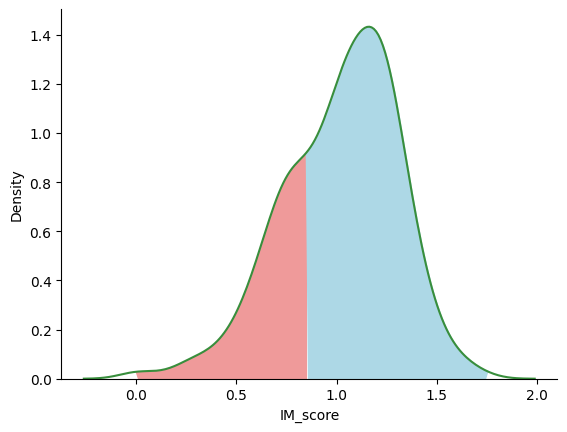

In [100]:
ax = sns.kdeplot(IM_segment["IM_score"],color='#388E3C')
kde_x, kde_y = ax.lines[0].get_data()

ax.fill_between(kde_x, kde_y, where=(kde_x<0.85) & (kde_x>0) , 
                interpolate=True, color='#EF9A9A')

ax.fill_between(kde_x, kde_y, where=(kde_x>0.85) & (kde_x<1.75) , 
                interpolate=True, color='lightblue')

sns.despine()